In [1]:
!pip install lightning

  Using cached lightning-2.2.5-py3-none-any.whl.metadata (53 kB)
  Using cached lightning_utilities-0.11.2-py3-none-any.whl.metadata (4.7 kB)
  Using cached torchmetrics-1.4.0.post0-py3-none-any.whl.metadata (19 kB)
  Using cached pytorch_lightning-2.2.5-py3-none-any.whl.metadata (21 kB)
  Using cached aiohttp-3.9.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.5 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached frozenlist-1.4.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multidict-6.0.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached yarl-1.9.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
Using cached lightning-2.2.5-py3-none-any.whl (2.0 MB)
Using cached lightning_utilities-0.11.2-py3-none-any.whl 

In [2]:
from Data_utils import *

2024-05-23 00:06:27.717117: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 00:06:27.759014: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 00:06:27.759054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 00:06:27.760219: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 00:06:27.767354: I tensorflow/core/platform/cpu_feature_guar

In [3]:
from Resnet import get_resnet_model
class DetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(DetectionModel, self).__init__()
        # Load a ResNet model but remove the fully connected layer
        base_model = get_resnet_model('resnet34',in_channels=1)
        
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Remove the last layer
        self.num_classes=num_classes

        # Output layer for class predictions
        self.classifier = nn.Linear(512, num_classes)  # 512 is the feature size of ResNet34 at the end

        # Output layers for bounding box predictions
        # 4 outputs per class: start_x, start_y, end_x, end_y
        self.bbox_regressor = nn.Linear(512, 4)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the features out

        # Class prediction
        classes = self.classifier(x)

        # Bounding box predictions
        bboxes = self.bbox_regressor(x)
        # Apply sigmoid to confine the outputs between 0 and 1
        bboxes = torch.sigmoid(bboxes)
        bboxes = bboxes.view(-1, 4)  # reshape to (batch_size, num_classes, 4)

        return classes, bboxes


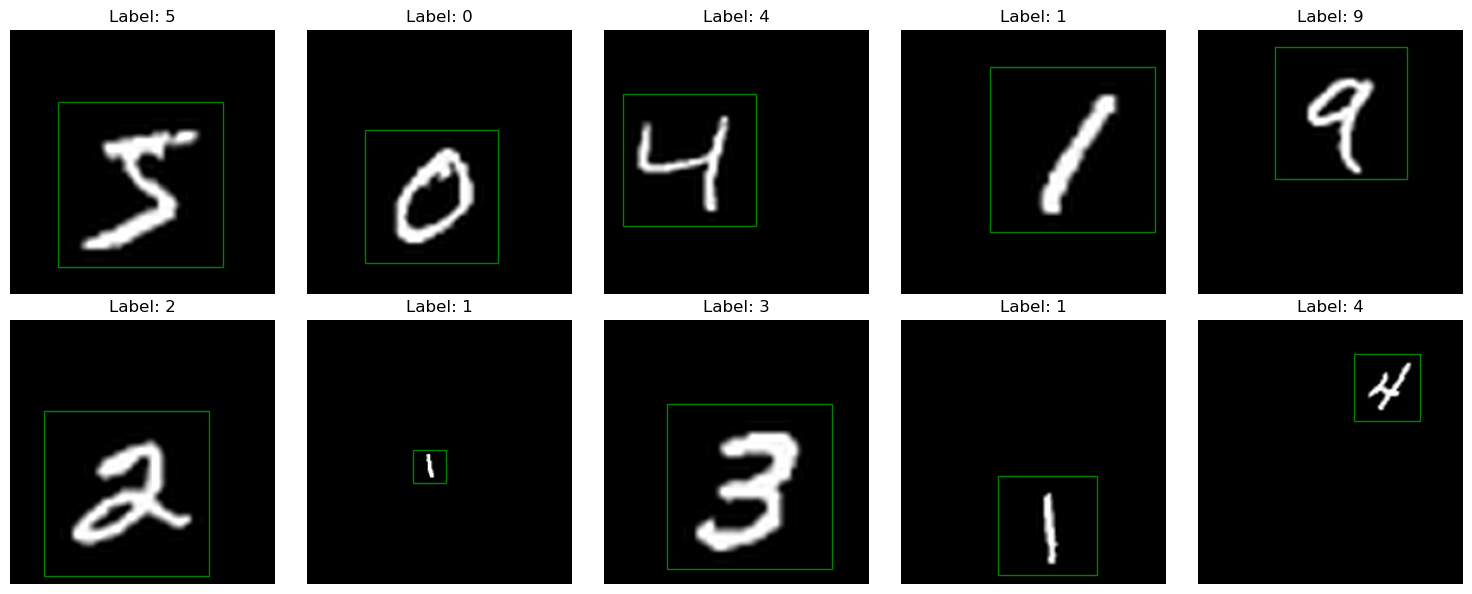

In [4]:
# Call the function to plot samples
dataset = MNISTSyntheticDataset(train=True)
plot_samples_with_labels_and_bbox(dataset)

In [5]:
# Train and Validation data loader
train_dataloader = DataLoader(MNISTSyntheticDataset(train=False), 
                        batch_size=32,  # Consider batch size based on your GPU memory
                        shuffle=True, 
                        num_workers=2)  # Increase this based on your system capabilities
val_dataloader = DataLoader(MNISTSyntheticDataset(train=False), 
                        batch_size=32,  # Consider batch size based on your GPU memory
                        shuffle=True, 
                        num_workers=2)  # Increase this based on your system capabilities



In [6]:
# CE + SmoothL1Loss
model = DetectionModel(num_classes=10).to('cuda')
loss_function = DetectionLoss(num_classes=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Assuming the train_loader and val_loader are properly defined
train_and_validate(model, train_dataloader, val_dataloader, optimizer, loss_function, epochs=20, visualize_after_train=True, log_dir='detection_logs_Resnet/resnet34_CE_Smoothl1')
                   

Training Epoch 1/20:   0%|          | 0/313 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/20] - Train classification Loss: 1.3901, Train iou Loss: 0.0155, Accuracy: 0.4868, IoU: 0.2642
Epoch [1/20] - Val classification Loss: 1.8651, Val iou Loss: 0.0153, Accuracy: 0.4967, IoU: 0.3368


Epoch [2/20] - Train classification Loss: 0.5556, Train iou Loss: 0.0061, Accuracy: 0.8124, IoU: 0.4180
Epoch [2/20] - Val classification Loss: 1.4785, Val iou Loss: 0.0040, Accuracy: 0.5608, IoU: 0.4638


Epoch [3/20] - Train classification Loss: 0.3898, Train iou Loss: 0.0042, Accuracy: 0.8720, IoU: 0.4665
Epoch [3/20] - Val classification Loss: 0.5769, Val iou Loss: 0.0034, Accuracy: 0.8202, IoU: 0.4878


Epoch [4/20] - Train classification Loss: 0.2832, Train iou Loss: 0.0034, Accuracy: 0.9123, IoU: 0.4922
Epoch [4/20] - Val classification Loss: 0.8079, Val iou Loss: 0.0032, Accuracy: 0.7326, IoU: 0.4664


Epoch [5/20] - Train classification Loss: 0.2201, Train iou Loss: 0.0027, Accuracy: 0.9314, IoU: 0.5225
Epoch [5/20] - Val classification Loss: 0.2207, Val iou Loss: 0.0022, Accuracy: 0.9292, IoU: 0.5459


Epoch [6/20] - Train classification Loss: 0.1821, Train iou Loss: 0.0025, Accuracy: 0.9445, IoU: 0.5270
Epoch [6/20] - Val classification Loss: 0.3279, Val iou Loss: 0.0020, Accuracy: 0.8967, IoU: 0.5656


Epoch [7/20] - Train classification Loss: 0.1742, Train iou Loss: 0.0024, Accuracy: 0.9464, IoU: 0.5373
Epoch [7/20] - Val classification Loss: 0.1610, Val iou Loss: 0.0015, Accuracy: 0.9514, IoU: 0.5873


Epoch [8/20] - Train classification Loss: 0.1551, Train iou Loss: 0.0021, Accuracy: 0.9493, IoU: 0.5404
Epoch [8/20] - Val classification Loss: 0.2321, Val iou Loss: 0.0020, Accuracy: 0.9333, IoU: 0.5310


Epoch [9/20] - Train classification Loss: 0.1452, Train iou Loss: 0.0020, Accuracy: 0.9540, IoU: 0.5493
Epoch [9/20] - Val classification Loss: 0.0755, Val iou Loss: 0.0013, Accuracy: 0.9757, IoU: 0.5922


Epoch [10/20] - Train classification Loss: 0.1133, Train iou Loss: 0.0019, Accuracy: 0.9671, IoU: 0.5613
Epoch [10/20] - Val classification Loss: 0.4366, Val iou Loss: 0.0015, Accuracy: 0.8667, IoU: 0.5915


Epoch [11/20] - Train classification Loss: 0.1196, Train iou Loss: 0.0018, Accuracy: 0.9628, IoU: 0.5632
Epoch [11/20] - Val classification Loss: 0.1649, Val iou Loss: 0.0015, Accuracy: 0.9464, IoU: 0.5875


Epoch [12/20] - Train classification Loss: 0.1155, Train iou Loss: 0.0017, Accuracy: 0.9640, IoU: 0.5803
Epoch [12/20] - Val classification Loss: 0.1442, Val iou Loss: 0.0018, Accuracy: 0.9546, IoU: 0.5454


Epoch [13/20] - Train classification Loss: 0.0937, Train iou Loss: 0.0016, Accuracy: 0.9710, IoU: 0.5781
Epoch [13/20] - Val classification Loss: 0.0806, Val iou Loss: 0.0010, Accuracy: 0.9734, IoU: 0.6427


Epoch [14/20] - Train classification Loss: 0.0933, Train iou Loss: 0.0016, Accuracy: 0.9717, IoU: 0.5807
Epoch [14/20] - Val classification Loss: 0.1001, Val iou Loss: 0.0012, Accuracy: 0.9697, IoU: 0.6105


Epoch [15/20] - Train classification Loss: 0.1028, Train iou Loss: 0.0016, Accuracy: 0.9666, IoU: 0.5818
Epoch [15/20] - Val classification Loss: 0.0720, Val iou Loss: 0.0010, Accuracy: 0.9758, IoU: 0.6458


Epoch [16/20] - Train classification Loss: 0.0864, Train iou Loss: 0.0015, Accuracy: 0.9740, IoU: 0.5842
Epoch [16/20] - Val classification Loss: 0.1125, Val iou Loss: 0.0010, Accuracy: 0.9654, IoU: 0.6432


Epoch [17/20] - Train classification Loss: 0.0882, Train iou Loss: 0.0015, Accuracy: 0.9724, IoU: 0.5874
Epoch [17/20] - Val classification Loss: 0.1210, Val iou Loss: 0.0010, Accuracy: 0.9637, IoU: 0.6418


Epoch [18/20] - Train classification Loss: 0.0805, Train iou Loss: 0.0014, Accuracy: 0.9725, IoU: 0.5964
Epoch [18/20] - Val classification Loss: 0.0880, Val iou Loss: 0.0014, Accuracy: 0.9725, IoU: 0.5798


Epoch [19/20] - Train classification Loss: 0.0749, Train iou Loss: 0.0015, Accuracy: 0.9753, IoU: 0.5926
Epoch [19/20] - Val classification Loss: 0.0601, Val iou Loss: 0.0010, Accuracy: 0.9805, IoU: 0.6523


Epoch [20/20] - Train classification Loss: 0.0872, Train iou Loss: 0.0014, Accuracy: 0.9747, IoU: 0.6033
Epoch [20/20] - Val classification Loss: 0.0585, Val iou Loss: 0.0011, Accuracy: 0.9815, IoU: 0.6282


In [7]:
# CE + IOU
model = DetectionModel(num_classes=10).to('cuda')
loss_function = CombinedLoss(num_classes=10,use_focal=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Assuming the train_loader and val_loader are properly defined
train_and_validate(model, train_dataloader, val_dataloader, optimizer, loss_function, epochs=20, visualize_after_train=True, log_dir='detection_logs_Resnet/resnet34_CE_IOU')


Epoch [1/20] - Train classification Loss: 1.3665, Train iou Loss: 0.5543, Accuracy: 0.4935, IoU: 0.4401
Epoch [1/20] - Val classification Loss: 1.6386, Val iou Loss: 0.5079, Accuracy: 0.4677, IoU: 0.4366


Epoch [2/20] - Train classification Loss: 0.5060, Train iou Loss: 0.4401, Accuracy: 0.8315, IoU: 0.5564
Epoch [2/20] - Val classification Loss: 0.6224, Val iou Loss: 0.5042, Accuracy: 0.8073, IoU: 0.4640


Epoch [3/20] - Train classification Loss: 0.3228, Train iou Loss: 0.4159, Accuracy: 0.8976, IoU: 0.5896
Epoch [3/20] - Val classification Loss: 1.4614, Val iou Loss: 0.3583, Accuracy: 0.6295, IoU: 0.6442


Epoch [4/20] - Train classification Loss: 0.2459, Train iou Loss: 0.3930, Accuracy: 0.9208, IoU: 0.6039
Epoch [4/20] - Val classification Loss: 1.2166, Val iou Loss: 0.4342, Accuracy: 0.6581, IoU: 0.6233


Epoch [5/20] - Train classification Loss: 0.1855, Train iou Loss: 0.3632, Accuracy: 0.9445, IoU: 0.6368
Epoch [5/20] - Val classification Loss: 0.1857, Val iou Loss: 0.3729, Accuracy: 0.9411, IoU: 0.6656


Epoch [6/20] - Train classification Loss: 0.1670, Train iou Loss: 0.3450, Accuracy: 0.9442, IoU: 0.6581
Epoch [6/20] - Val classification Loss: 0.1897, Val iou Loss: 0.3647, Accuracy: 0.9455, IoU: 0.6078


Epoch [7/20] - Train classification Loss: 0.1486, Train iou Loss: 0.3287, Accuracy: 0.9536, IoU: 0.6719
Epoch [7/20] - Val classification Loss: 0.1946, Val iou Loss: 0.2853, Accuracy: 0.9366, IoU: 0.7314


Epoch [8/20] - Train classification Loss: 0.1416, Train iou Loss: 0.3027, Accuracy: 0.9560, IoU: 0.6992
Epoch [8/20] - Val classification Loss: 0.0999, Val iou Loss: 0.2887, Accuracy: 0.9674, IoU: 0.6803


Epoch [9/20] - Train classification Loss: 0.1205, Train iou Loss: 0.3004, Accuracy: 0.9636, IoU: 0.7054
Epoch [9/20] - Val classification Loss: 0.2838, Val iou Loss: 0.2640, Accuracy: 0.9104, IoU: 0.7480


Epoch [10/20] - Train classification Loss: 0.1152, Train iou Loss: 0.2971, Accuracy: 0.9638, IoU: 0.7099
Epoch [10/20] - Val classification Loss: 0.1139, Val iou Loss: 0.2337, Accuracy: 0.9637, IoU: 0.7775


Epoch [11/20] - Train classification Loss: 0.1052, Train iou Loss: 0.2702, Accuracy: 0.9677, IoU: 0.7376
Epoch [11/20] - Val classification Loss: 0.1073, Val iou Loss: 0.2417, Accuracy: 0.9660, IoU: 0.7604


Epoch [12/20] - Train classification Loss: 0.0953, Train iou Loss: 0.2648, Accuracy: 0.9703, IoU: 0.7474
Epoch [12/20] - Val classification Loss: 0.1308, Val iou Loss: 0.3334, Accuracy: 0.9600, IoU: 0.7236


Epoch [13/20] - Train classification Loss: 0.1002, Train iou Loss: 0.2568, Accuracy: 0.9685, IoU: 0.7526
Epoch [13/20] - Val classification Loss: 0.1265, Val iou Loss: 0.2072, Accuracy: 0.9586, IoU: 0.8030


Epoch [14/20] - Train classification Loss: 0.0901, Train iou Loss: 0.2444, Accuracy: 0.9718, IoU: 0.7658
Epoch [14/20] - Val classification Loss: 0.1013, Val iou Loss: 0.2231, Accuracy: 0.9694, IoU: 0.8015


Epoch [15/20] - Train classification Loss: 0.0859, Train iou Loss: 0.2326, Accuracy: 0.9723, IoU: 0.7780
Epoch [15/20] - Val classification Loss: 0.0953, Val iou Loss: 0.2216, Accuracy: 0.9698, IoU: 0.7550


Epoch [16/20] - Train classification Loss: 0.0789, Train iou Loss: 0.2203, Accuracy: 0.9747, IoU: 0.7819
Epoch [16/20] - Val classification Loss: 0.1036, Val iou Loss: 0.2323, Accuracy: 0.9679, IoU: 0.7914


Epoch [17/20] - Train classification Loss: 0.0730, Train iou Loss: 0.2179, Accuracy: 0.9773, IoU: 0.7925
Epoch [17/20] - Val classification Loss: 0.0524, Val iou Loss: 0.2181, Accuracy: 0.9811, IoU: 0.7840


Epoch [18/20] - Train classification Loss: 0.0676, Train iou Loss: 0.2139, Accuracy: 0.9776, IoU: 0.8036
Epoch [18/20] - Val classification Loss: 0.0579, Val iou Loss: 0.2287, Accuracy: 0.9818, IoU: 0.7623


Epoch [19/20] - Train classification Loss: 0.0698, Train iou Loss: 0.2252, Accuracy: 0.9784, IoU: 0.7906
Epoch [19/20] - Val classification Loss: 0.0566, Val iou Loss: 0.1760, Accuracy: 0.9836, IoU: 0.8445


Epoch [20/20] - Train classification Loss: 0.0751, Train iou Loss: 0.2127, Accuracy: 0.9756, IoU: 0.7934
Epoch [20/20] - Val classification Loss: 0.0554, Val iou Loss: 0.1967, Accuracy: 0.9830, IoU: 0.8153


In [8]:
# Focal loss + IOU
model = DetectionModel(num_classes=10).to('cuda')
loss_function = CombinedLoss(num_classes=10,use_focal=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Assuming the train_loader and val_loader are properly defined
train_and_validate(model, train_dataloader, val_dataloader, optimizer, loss_function, epochs=20, visualize_after_train=True, log_dir='detection_logs_Resnet/resnet34_focal_IOU')


Epoch [1/20] - Train classification Loss: 0.3103, Train iou Loss: 0.4884, Accuracy: 0.3553, IoU: 0.5162
Epoch [1/20] - Val classification Loss: 0.2425, Val iou Loss: 0.4136, Accuracy: 0.4701, IoU: 0.5815


Epoch [2/20] - Train classification Loss: 0.1462, Train iou Loss: 0.4206, Accuracy: 0.6412, IoU: 0.5856
Epoch [2/20] - Val classification Loss: 0.1489, Val iou Loss: 0.3789, Accuracy: 0.6311, IoU: 0.5320


Epoch [3/20] - Train classification Loss: 0.0832, Train iou Loss: 0.3735, Accuracy: 0.7871, IoU: 0.6301
Epoch [3/20] - Val classification Loss: 0.1701, Val iou Loss: 0.4131, Accuracy: 0.6135, IoU: 0.5620


Epoch [4/20] - Train classification Loss: 0.0580, Train iou Loss: 0.3528, Accuracy: 0.8521, IoU: 0.6497
Epoch [4/20] - Val classification Loss: 0.0828, Val iou Loss: 0.2559, Accuracy: 0.7903, IoU: 0.7767


Epoch [5/20] - Train classification Loss: 0.0469, Train iou Loss: 0.3201, Accuracy: 0.8778, IoU: 0.6834
Epoch [5/20] - Val classification Loss: 0.1021, Val iou Loss: 0.3091, Accuracy: 0.7589, IoU: 0.6604


Epoch [6/20] - Train classification Loss: 0.0359, Train iou Loss: 0.2938, Accuracy: 0.9045, IoU: 0.7138
Epoch [6/20] - Val classification Loss: 0.0335, Val iou Loss: 0.3036, Accuracy: 0.9102, IoU: 0.7435


Epoch [7/20] - Train classification Loss: 0.0309, Train iou Loss: 0.2839, Accuracy: 0.9201, IoU: 0.7276
Epoch [7/20] - Val classification Loss: 0.0469, Val iou Loss: 0.2733, Accuracy: 0.8591, IoU: 0.7380


Epoch [8/20] - Train classification Loss: 0.0289, Train iou Loss: 0.2656, Accuracy: 0.9247, IoU: 0.7484
Epoch [8/20] - Val classification Loss: 0.0372, Val iou Loss: 0.2698, Accuracy: 0.8947, IoU: 0.7600


Epoch [9/20] - Train classification Loss: 0.0231, Train iou Loss: 0.2455, Accuracy: 0.9381, IoU: 0.7651
Epoch [9/20] - Val classification Loss: 0.0205, Val iou Loss: 0.2116, Accuracy: 0.9466, IoU: 0.7886


Epoch [10/20] - Train classification Loss: 0.0232, Train iou Loss: 0.2424, Accuracy: 0.9356, IoU: 0.7721
Epoch [10/20] - Val classification Loss: 0.0581, Val iou Loss: 0.2414, Accuracy: 0.8351, IoU: 0.7510


Epoch [11/20] - Train classification Loss: 0.0225, Train iou Loss: 0.2267, Accuracy: 0.9399, IoU: 0.7893
Epoch [11/20] - Val classification Loss: 0.0239, Val iou Loss: 0.1940, Accuracy: 0.9336, IoU: 0.8399


Epoch [12/20] - Train classification Loss: 0.0187, Train iou Loss: 0.2165, Accuracy: 0.9499, IoU: 0.7969
Epoch [12/20] - Val classification Loss: 0.0125, Val iou Loss: 0.2267, Accuracy: 0.9679, IoU: 0.7656


Epoch [13/20] - Train classification Loss: 0.0177, Train iou Loss: 0.2074, Accuracy: 0.9514, IoU: 0.8063
Epoch [13/20] - Val classification Loss: 0.0190, Val iou Loss: 0.2084, Accuracy: 0.9502, IoU: 0.8090


Epoch [14/20] - Train classification Loss: 0.0163, Train iou Loss: 0.2010, Accuracy: 0.9542, IoU: 0.8151
Epoch [14/20] - Val classification Loss: 0.0208, Val iou Loss: 0.1902, Accuracy: 0.9439, IoU: 0.8303


Epoch [15/20] - Train classification Loss: 0.0143, Train iou Loss: 0.1948, Accuracy: 0.9597, IoU: 0.8255
Epoch [15/20] - Val classification Loss: 0.0743, Val iou Loss: 0.2051, Accuracy: 0.8384, IoU: 0.7929


Epoch [16/20] - Train classification Loss: 0.0151, Train iou Loss: 0.1940, Accuracy: 0.9588, IoU: 0.8238
Epoch [16/20] - Val classification Loss: 0.0118, Val iou Loss: 0.1713, Accuracy: 0.9665, IoU: 0.8372


Epoch [17/20] - Train classification Loss: 0.0149, Train iou Loss: 0.1877, Accuracy: 0.9592, IoU: 0.8351
Epoch [17/20] - Val classification Loss: 0.0158, Val iou Loss: 0.2261, Accuracy: 0.9572, IoU: 0.7938


Epoch [18/20] - Train classification Loss: 0.0135, Train iou Loss: 0.1847, Accuracy: 0.9639, IoU: 0.8349
Epoch [18/20] - Val classification Loss: 0.0151, Val iou Loss: 0.1492, Accuracy: 0.9590, IoU: 0.8805


Epoch [19/20] - Train classification Loss: 0.0126, Train iou Loss: 0.1794, Accuracy: 0.9661, IoU: 0.8383
Epoch [19/20] - Val classification Loss: 0.0227, Val iou Loss: 0.1807, Accuracy: 0.9431, IoU: 0.8386


Epoch [20/20] - Train classification Loss: 0.0129, Train iou Loss: 0.1783, Accuracy: 0.9646, IoU: 0.8420
Epoch [20/20] - Val classification Loss: 0.0095, Val iou Loss: 0.1681, Accuracy: 0.9721, IoU: 0.8401


In [9]:
!tar -zcvf detection_logs_Resnet.tar.gz detection_logs

detection_logs/
detection_logs/resnet34_CE_IOU/
detection_logs/resnet34_CE_IOU/events.out.tfevents.1715375754.jupyter-ec23457.16534.1
detection_logs/resnet34_CE_IOU/events.out.tfevents.1716423079.jupyter-ec23457.5312.1
detection_logs/resnet34_CE_IOU/events.out.tfevents.1714915265.jupyter-ec23457.118610.1
detection_logs/resnet34_CE_IOU/visualizations/
detection_logs/resnet34_CE_IOU/visualizations/epoch_7_positive_visualizations.png
detection_logs/resnet34_CE_IOU/visualizations/epoch_1_positive_visualizations.png
detection_logs/resnet34_CE_IOU/visualizations/epoch_14_positive_visualizations.png
detection_logs/resnet34_CE_IOU/visualizations/epoch_7_negative_visualizations.png
detection_logs/resnet34_CE_IOU/visualizations/epoch_11_negative_visualizations.png
detection_logs/resnet34_CE_IOU/visualizations/epoch_10_positive_visualizations.png
detection_logs/resnet34_CE_IOU/visualizations/epoch_3_positive_visualizations.png
detection_logs/resnet34_CE_IOU/visualizations/epoch_5_positive_visuali